In [1]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from torch.utils.data import Dataset
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
dataset_paths = []
records_folder = "../data/reasoning_nuscenes"
for name in os.listdir(records_folder):
   dir = os.path.join(records_folder, name)
   if os.path.isdir(dir):
      dataset_paths.append(dir)

print(dataset_paths)

['../data/record\\Town01_100npcs_1', '../data/record\\Town01_200npcs_1', '../data/record\\Town02_100npcs_1', '../data/record\\Town02_200npcs_1', '../data/record\\Town03_100npcs_1', '../data/record\\Town03_200npcs_1', '../data/record\\Town04_100npcs_1', '../data/record\\Town04_200npcs_1', '../data/record\\Town05_100npcs_1', '../data/record\\Town05_200npcs_1', '../data/record\\Town06_100npcs_1', '../data/record\\Town06_100npcs_2', '../data/record\\Town06_200npcs_1', '../data/record\\Town06_200npcs_2', '../data/record\\Town12_2000npcs_1', '../data/record\\Town12_200npcs_2', '../data/record\\Town12_200npcs_3', '../data/record\\Town15_500npcs']


14248


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
11398 2850


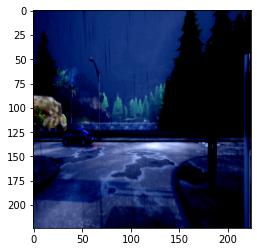

In [3]:
class RedLightPredictionDataset(Dataset):
    def __init__(self, dataset_paths, return_metadata=False, transform=None, sensor_range=50.0, bev_range=50.0):
        super().__init__()
        self.records = []
        self.return_metadata = return_metadata
        self.transform = transform
        self.sensor_range = sensor_range
        self.bev_range = bev_range

        for path in dataset_paths:
            self.read_data_folder(path)
    
    def read_data_folder(self, path):
        for agent in os.listdir(os.path.join(path, 'agents')):
            agent_folder = os.path.join(path, 'agents', agent)

            rec = {}
            for line in open(os.path.join(agent_folder, 'gt_location', 'data.jsonl'), 'r'):
                record = json.loads(line)
                rec[record['frame']] = {
                    'location': record['location'],
                    'rotation': record['rotation'],
                }
            
            for line in open(os.path.join(agent_folder, 'gt_traffic_light', 'data.jsonl'), 'r'):
                record = json.loads(line)
                rec[record['frame']]['is_red_light'] = 0
                if record['current_traffic_light'] is not None:
                    if record['current_traffic_light']['state'] == 'Red':
                        rec[record['frame']]['is_red_light'] = 1

            for filename in os.listdir(os.path.join(agent_folder, 'front_camera')):
                frame = int(filename.split('.')[0])
                rec[frame]['image_path'] = os.path.join(agent_folder, 'front_camera', filename)
                rec[frame]['output_path'] = os.path.join(agent_folder, 'pred_traffic_light', 'data.jsonl'),

            for frame, r in rec.items():
                r['frame'] = frame
                self.records.append(r)
    
    def __len__(self):
        return len(self.records)
    
    def __getitem__(self, index):
        record = self.records[index]
        agent_image = cv2.imread(record['image_path'])
        agent_image = cv2.cvtColor(agent_image, cv2.COLOR_BGR2RGB)
        y = record['is_red_light']

        image = agent_image

        if self.transform is not None:
            image = self.transform(image)

        if self.return_metadata:
            return image, y, self.records[index]
        return image, y

preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = RedLightPredictionDataset(dataset_paths, transform=preprocess)

print(len(dataset))
img, label = dataset[0]
plt.imshow(np.array(img).transpose(1, 2, 0))
print(label)

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
print(train_size, test_size)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(233))

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
)


In [4]:
label_counts = {}
for i in range(len(dataset)):
    _, label = dataset[i]
    if label not in label_counts:
        label_counts[label] = 0
    label_counts[label] += 1

print(label_counts)

{0: 9567, 1: 4681}


In [5]:
from torch import nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

class RedLightModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
        self.linear = nn.Linear(1000, 2)

    def forward(self, x):
        x = self.backbone(x)
        x = self.linear(x)
        return x

model = RedLightModel()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0)

save_dir = '../tmp/RedLightPrediction/'
os.makedirs(save_dir, exist_ok=True)


cuda:0


Using cache found in C:\Users\IX/.cache\torch\hub\pytorch_vision_v0.10.0
d:\Workspace\Autopilot\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Workspace\Autopilot\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
try:
    model.load_state_dict(torch.load(os.path.join(save_dir, 'model.pth')))
    optimizer.load_state_dict(torch.load(os.path.join(save_dir, 'optimizer.pth')))
except Exception as e:
    print(e)

In [8]:
num_epochs = 20
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0.0
    for i, data in enumerate(train_loader):
        x, y = data
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)

        with torch.no_grad():
            _, predictions = torch.max(y_pred, 1)
            train_correct = train_correct + (predictions == y).float().sum()

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    train_acc = train_correct / len(train_dataset)
    print(f'Epoch {epoch} training loss: {train_loss} accuracy: {train_acc}')

    with torch.no_grad():
        test_loss = 0.0
        test_correct = 0.0
        for i, data in enumerate(test_loader):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            _, predictions = torch.max(y_pred, 1)
            test_correct = test_correct + (predictions == y).float().sum()
            test_loss += loss.item()
        test_loss = test_loss / len(test_loader)
        test_acc = test_correct / len(test_dataset)
        print(f'Epoch {epoch} testing loss: {test_loss} accuracy: {test_acc}')


Epoch 0 training loss: 0.6387748258269351 accuracy: 0.6629948616027832
Epoch 0 testing loss: 0.38466648509105045 accuracy: 0.8335626125335693
Epoch 1 training loss: 0.32544944143813587 accuracy: 0.8702237606048584
Epoch 1 testing loss: 0.2729297950863838 accuracy: 0.888583242893219
Epoch 2 training loss: 0.20904150791466236 accuracy: 0.9239242672920227
Epoch 2 testing loss: 0.2001373159388701 accuracy: 0.9270976781845093
Epoch 3 training loss: 0.15392140452952488 accuracy: 0.9462994933128357
Epoch 3 testing loss: 0.1929991419116656 accuracy: 0.9325997233390808
Epoch 4 training loss: 0.17057809687179068 accuracy: 0.9376936554908752
Epoch 4 testing loss: 0.18277834355831146 accuracy: 0.9408528208732605
Epoch 5 training loss: 0.11686621901943632 accuracy: 0.9593803882598877
Epoch 5 testing loss: 0.21792371633152166 accuracy: 0.928473174571991
Epoch 6 training loss: 0.08611932093196589 accuracy: 0.9710843563079834
Epoch 6 testing loss: 0.19733712015052637 accuracy: 0.9394773244857788
Epoch

In [9]:
torch.save(model.state_dict(), os.path.join(save_dir, 'model.pth'))
torch.save(optimizer.state_dict(), os.path.join(save_dir, 'optimizer.pth'))


In [7]:
def write_pred():
    dataset = RedLightPredictionDataset(dataset_paths, return_metadata=True, transform=preprocess)
    dataloader = DataLoader(
        dataset,
        batch_size=8,
        shuffle=False,
    )

    save_objs = {}

    total_loss = 0.0
    total_samples = 0.0
    total_correct = 0.0
    for i, data in enumerate(dataloader):
        x, y, meta = data
        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)
        loss = criterion(y_pred, y)

        with torch.no_grad():
            _, predictions = torch.max(y_pred, 1)
            total_samples += y.shape[0]
            total_correct += (predictions == y).float().sum()

        for i in range(y.shape[0]):
            output_path = meta['output_path'][0][i]
            if output_path not in save_objs:
                save_objs[output_path] = {}
            frame = int(meta['frame'][i])
            if frame not in save_objs[output_path]:
                save_objs[output_path][frame] = {}
            save_objs[output_path][frame] = {
                'frame': int(meta['frame'][i]),
                'is_under_red_traffic_light': int(predictions[i]),
                'is_under_red_traffic_light_gt': int(y[i]),
            }

        total_loss += loss.item()
    total_loss = total_loss / len(dataloader)
    total_acc = total_correct / total_samples
    print(f'Average loss: {total_loss} accuracy: {total_acc}')

    for filepath, frames in save_objs.items():
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        with open(filepath, 'w') as file:
            for frame in sorted(list(frames.keys())):
                line = json.dumps(save_objs[filepath][frame])
                file.write(line+"\n")

write_pred()

Average loss: 1.3882878296760186 accuracy: 0.6075238585472107
